# Fast Gradient Sign Attack (FGSA) Tutorial 

Fast Gradient Sign Attack (FGSA) was first introduced in the paper "Explaining and Harnessing Adversarial Examples" by Ian Goodfellow et al. in 2015. Accordingly, this tutorial uses the paper as its primary source, and the content directly reflects its findings. The paper highlights that several machine learning models consistently misclassify adversarial examples. A straightforward explanation for adversarial examples is already well-explained in the paper (p. 1), which defines them as:

"inputs formed by applying small but intentionally worst-case perturbations to examples from the dataset, such that the perturbed input results in the model outputting an incorrect answer with high confidence."

These adversarial examples can be generated using the Fast Gradient Sign Attack. Adversarial examples, despite their differences often imperceptible to the human eye from regular, correctly classified examples, are able to fool neural networks. Furthermore, successful adversarial examples generated to fool one model often deceive other classifier models, even those with different architectures or trained on different subsets of the training data. This property is known as transferability.

The paper delves into a proposed hypothesis for why these adversarial examples work on machine learning models, as well as examining other prevailing hypotheses.

Despite previous speculations that this effect is due to the nonlinearity of deep models, Goodfellow et al. hypothesize that the effectiveness of adversarial examples is, counterintuitively, due to the linear nature of neural networks (Section 2 of the paper). This linearity makes them fail to resist carefully crafted linear adversarial perturbations. Since many machine learning components and models, such as LSTMs, ReLUs, and maxout networks, are often designed to behave linearly for easier optimization, this attack can affect a wide range of models.

To fully understand how FGSA is implemented and how it works, one must look deeper into its mathematical foundation. Fortunately, the mathematics are not overly complicated, which allows for the _fast_ generation of such adversarial examples.

The Fast Gradient Sign Attack is a white-box attack; meaning that to execute it, one must have knowledge of the model's internals—specifically, the model's parameters (weights) and gradients. Despite this, it is possible to apply FGSA to black-box models by first using techniques such as model inversion to estimate the model's parameters or by leveraging the transferability property of adversarial examples.

FGSA consists of adding perturbations—small changes—to the input pixels aligned to the direction of the gradient of the loss function with respect to the correct input image. This method is especially effective with high-dimensional input, as the effects of these directed perturbations accumulate across many dimensions, causing the model's activation for the incorrect class to grow.


These intentional perturbations must be at least as large as the precision of an individual input feature. For example, a digital image using 8 bits per pixel discards any information below 1/255 of the dynamic range. Due to this input feature precision limitation, a classifier will respond identically in its classification to an input $\mathbf{x}$ and its adversarial input $\mathbf{x'} = \mathbf{x} + \mathbf{\eta}$, where $\mathbf{\eta}$ signifies perturbation smaller than the precision of the features. To generate effective adversarial examples, a value $\epsilon$ (epsilon) that scales the perturbation must be selected. This $\epsilon$ should correspond to a change that is perceptible by the model after input data (e.g., image pixel values) is converted to real numbers for processing. For an 8-bit image (256 possible values per channel) normalized to the range $[0, 1]$, the smallest such step is $\frac{1}{255} \approx 0.0039$. Thus, a typical $\epsilon$ might be around this value. However, if specific normalization occurs, such as to the range $[-1, 1]$ (e.g., by $(\text{pixel} - 128) / 128$), the smallest step size becomes $\frac{2}{255} \approx 0.0078$.

To understand the core idea, consider a linear model where the activation is the dot product between a weight vector $\mathbf{w}$ and an input $\mathbf{x}$. if we introduce an adversarial example $\mathbf{x'} = \mathbf{x} + \mathbf{\eta}$ (where $\mathbf{\eta}$ is the perturbation), its activation in this linear context becomes:

$$\mathbf{w}^T \mathbf{x'} = \mathbf{w}^T (\mathbf{x} + \mathbf{\eta}) = \mathbf{w}^T \mathbf{x} + \mathbf{w}^T \mathbf{\eta}$$

The term $\mathbf{w}^T \mathbf{\eta}$ represents the change—or growth—in activation caused by the adversarial perturbation $\mathbf{\eta}$. To maximize this increase (and thereby maximize the impact on the model's output or loss), the perturbation $\mathbf{\eta}$ should be chosen to align with $\mathbf{w}$. Specifically, if each component of the perturbation $\eta_i$ is set to $\epsilon \cdot \text{sign}(w_i)$, the increase $\mathbf{w}^T \mathbf{\eta}$ is maximized. The $\text{sign}(\cdot)$ function, applied element-wise to a vector, assigns $+1$ to elements with values above $0$, $-1$ to elements with values below $0$, and $0$ to elements that are exactly $0$.

The Fast Gradient Sign Attack (FGSA) leverages this intuition. Instead of using the model's weights $\mathbf{w}$ directly (which is most straightforward for a purely linear model), FGSA uses the gradient of the model's cost function $J$ with respect to the input $\mathbf{x}$. This gradient, $\nabla_{\mathbf{x}} J$, indicates the direction in which a small change to $\mathbf{x}$ will most significantly increase the cost $J$. The perturbation $\mathbf{\eta}$ is therefore crafted as follows:
$$\mathbf{\eta} = \epsilon \cdot \text{sign}(\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y_{true}))$$

where:
* $\epsilon$ (epsilon) is a small scalar that controls the magnitude of the perturbation. As discussed previously, its value is often chosen based on the precision of the input data (e.g., the smallest representable change in pixel values after normalization).
* $J(\mathbf{\theta}, \mathbf{x}, y_{true})$ is the cost function used to train the model.
* $\mathbf{\theta}$ represents the parameters (weights and biases) of the model.
* $\mathbf{x}$ is the original, legitimate input to the model.
* $y_{true}$ is the true target label associated with $\mathbf{x}$ (in supervised learning settings).
* $\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y_{true})$ is the gradient of the cost function with respect to the input $\mathbf{x}$.
* $\text{sign}(\cdot)$ is the sign function, applied element-wise.

The final adversarial example, $\mathbf{x'}$, is then generated by adding this perturbation to the original input:
$$\mathbf{x'} = \mathbf{x} + \mathbf{\eta}$$

The intuition from the linear case (where activation grows by $\mathbf{w}^T \mathbf{\eta}$) helps explain FGSA's effectiveness, especially in high-dimensional spaces. If the input $\mathbf{x}$ (and consequently the gradient vector $\nabla_{\mathbf{x}} J$) has many dimensions, the sum of these small, intentionally aligned perturbations (scaled by $\epsilon$) can accumulate to cause a significant overall change in the model's loss, leading to misclassification. For a more in-depth explanation of this amplification effect in high dimensions, I refer you to page 2 of the original paper by Goodfellow et al. (2015).

The paper reports (p. 4) that a shallow softmax classifier had an error rate of $99.9\%$ on the MNIST test set using an $\epsilon$ of $0.25$, with an average confidence of $79.3\%$ on these misclassifications.


To create models that are not as easily fooled by FGSA adversarial examples, adversarial training can be performed. This involves systematically integrating worst-case (or near worst-case) perturbations into the training process. This type of training can generalize across different domains, including NLP and computer vision (as explored in the paper). It involves training the model on a mix of original data and these adversarially perturbed examples. The paper demonstrates that adversarial training can be an effective regularization technique (Section 6). That being said, adversarial training is most beneficial if the model's architecture has sufficient capacity, as suggested by the universal approximator theorem. This theorem states that a neural network with at least one hidden layer and a sufficient number of units can approximate any continuous function to an arbitrary degree of accuracy, implying it could learn to correctly classify both clean and adversarial inputs.

Despite its superficial similarity to data augmentation frameworks, adversarial training employing FGSA-generated examples is quite different from traditional data augmentation. Data augmentation usually relies on augmentations or transformations that are expected to occur naturally in the test set (e.g., rotations, crops). In contrast, adversarial examples generated by FGSA are highly unlikely to occur naturally. Instead, as stated in the paper, they expose flaws in how the model conceptualizes its decision function. These adversarial examples can be generated on-the-fly during training rather than requiring a fixed, pre-generated dataset.



Let's look into how to implement FGSA now!


In [1]:
!pip install torchvision
!pip install kagglehub[pandas-datasets]


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import xml.etree.ElementTree as ET
import os
import pandas as pd
import random
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split

!pwd

/home/vic/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/vic/files/AI_safety/AISIG_tutorial_notebook


# Dataset Preparation

In this tutorial, we will use a publicly available road sign dataset from Kaggle to demonstrate the Fast Gradient Sign Attack (FGSA). Data exploration is a crucial initial step in any project.

**Dataset**: [Road Sign Detection](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection/data)

This section covers:

-   Dataset loading and preparation
-   Basic data exploration


In [3]:
dataset_path = kagglehub.dataset_download("andrewmvd/road-sign-detection")

print(f"Dataset downloaded to {dataset_path}")

# since the downloaded dataset has two folders for info (annotations) and input (images)
annotations_path = os.path.join(dataset_path, "annotations")
images_path = os.path.join(dataset_path, "images")
dataset_list_dict = []
dataset_dict = {}
check = 0
parsed_data = []

if os.path.exists(annotations_path):
    print(f"Annotations path exists: {annotations_path}")
    xml_files = [f for f in os.listdir(annotations_path) if f.endswith('.xml')]
    print(f"Found {len(xml_files)} XML files.")

    for xml_file in xml_files:
        full_xml_path = os.path.join(annotations_path, xml_file)
        try:
            tree = ET.parse(full_xml_path)
            root = tree.getroot()
            
            image_file_name = root.find("filename").text
            image_file_path = os.path.join(images_path, image_file_name)

            image_size_element = root.find("size")
            img_width = int(image_size_element.find("width").text)
            img_height = int(image_size_element.find("height").text)

            for obj_element in root.findall("object"):
                label = obj_element.find("name").text
                bndbox_element = obj_element.find("bndbox")
                xmin = int(bndbox_element.find("xmin").text)
                ymin = int(bndbox_element.find("ymin").text)
                xmax = int(bndbox_element.find("xmax").text)
                ymax = int(bndbox_element.find("ymax").text)
                
                parsed_data.append({
                    "image_path": image_file_path,
                    "label": label,
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax,
                    "image_width": img_width,
                    "image_height": img_height
                })
        except Exception as e:
            print(f"Error reading or parsing {full_xml_path}: {e}")
else:
    print(f"An error occured using the annotations path: {annotations_path}")

# convert to Pandas DataFrame
df = pd.DataFrame(parsed_data)


Dataset downloaded to /home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1
Annotations path exists: /home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/annotations
Found 877 XML files.


Now that we have successfully parsed the data and loaded it as a Pandas DataFrame, we can examine examples from the dataset and explore underlying statistics/patterns. This process is referred to as data exploration.

In [4]:
print("\n--- DataFrame Samples ---")
if not df.empty:
    pd.set_option('display.expand_frame_repr', False)
    print(df.head(20))
    print(f"\nTotal objects (bounding boxes) found: {len(df)}")
    print(f"Total unique images: {df['image_path'].nunique()}")
else:
    print("DataFrame is empty. No data was parsed.")



--- DataFrame Samples ---
                                           image_path         label  xmin  ymin  xmax  ymax  image_width  image_height
0   /home/vic/.cache/kagglehub/datasets/andrewmvd/...    speedlimit   133   110   174   154          300           400
1   /home/vic/.cache/kagglehub/datasets/andrewmvd/...    speedlimit   143   175   168   204          300           400
2   /home/vic/.cache/kagglehub/datasets/andrewmvd/...    speedlimit    88   160   143   216          300           400
3   /home/vic/.cache/kagglehub/datasets/andrewmvd/...    speedlimit   114   118   173   176          300           400
4   /home/vic/.cache/kagglehub/datasets/andrewmvd/...    speedlimit   111   210   170   269          300           400
5   /home/vic/.cache/kagglehub/datasets/andrewmvd/...    speedlimit    90   251   118   279          300           400
6   /home/vic/.cache/kagglehub/datasets/andrewmvd/...    speedlimit    92   205   120   233          300           400
7   /home/vic/.cache/

------------------------------------------------------------------------------------------------

--- Class Distribution ---
speedlimit      783
crosswalk       200
trafficlight    170
stop             91
Name: label, dtype: int64


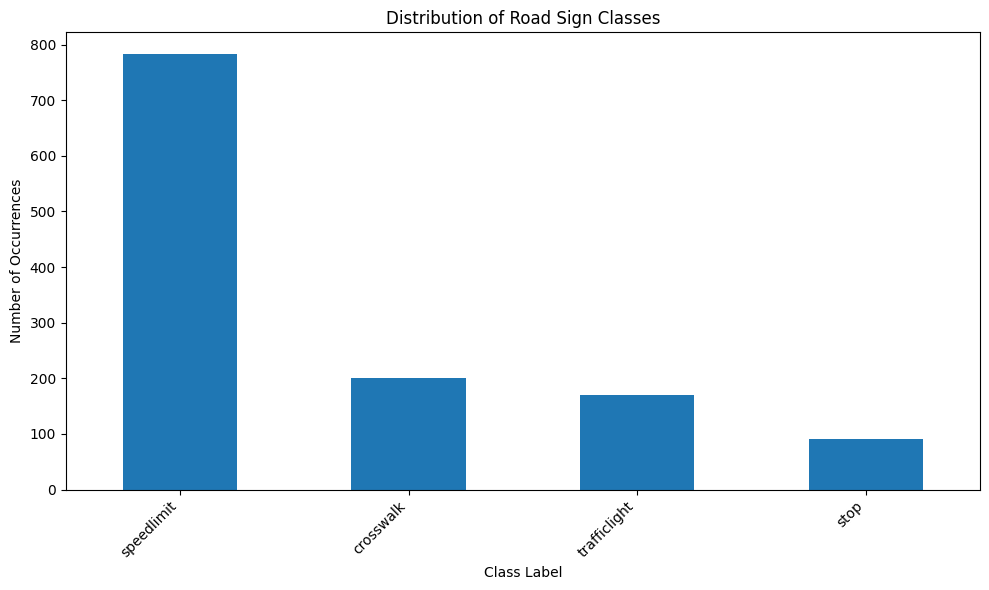


--- Images with most objects/labels ---
image_path
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road820.png    8
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road821.png    8
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road826.png    8
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road819.png    6
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road822.png    6
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road825.png    6
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road179.png    5
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road21.png     5
/home/vic/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/road43.png     5
/home/vic/.cache/kagglehub/datasets/and

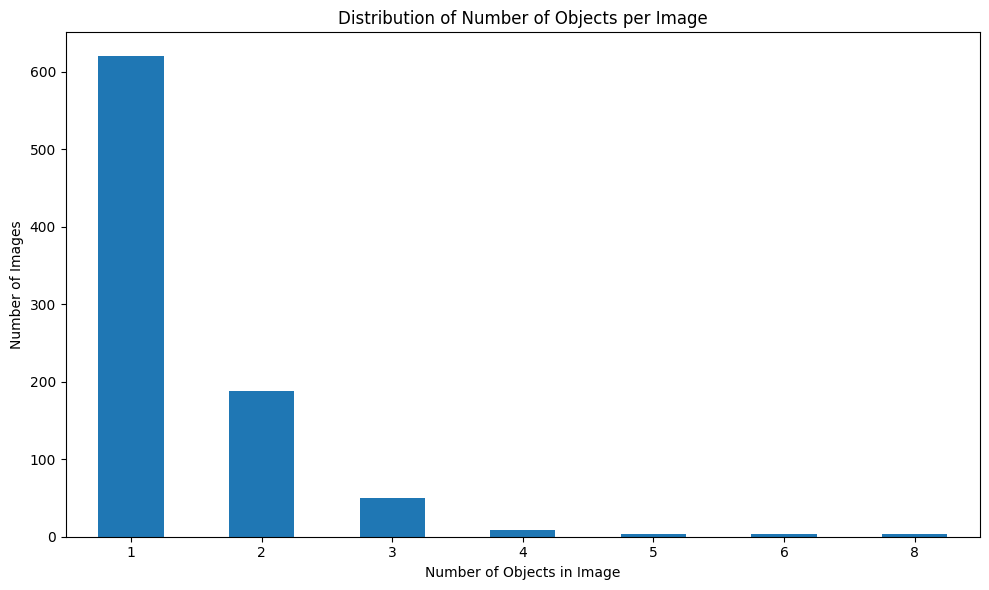

In [5]:
if not df.empty:
    print("------------------------------------------------------------------------------------------------")

    print("\n--- Class Distribution ---")
    class_counts = df['label'].value_counts()
    print(class_counts)
    
    # plot class distribution
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Distribution of Road Sign Classes')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # print top number of objects per image
    print("\n--- Images with most objects/labels ---")
    objects_per_image = df.groupby('image_path').size().sort_values(ascending=False)
    pd.set_option('display.expand_frame_repr', False)
    print(objects_per_image.head(20)) # show images with most objects
    
    plt.figure(figsize=(10, 6))
    objects_per_image.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Number of Objects per Image')
    plt.xlabel('Number of Objects in Image')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping data exploration as DataFrame is empty.")




--- Visualizing Sample Images with Bounding Boxes ---


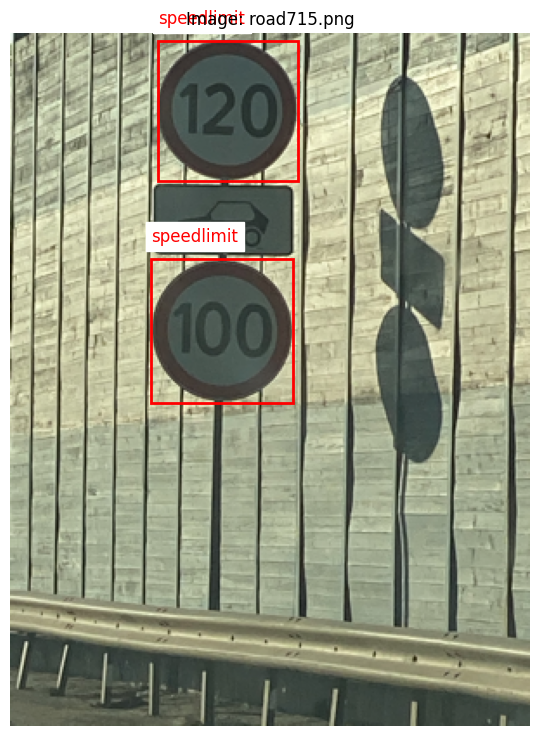

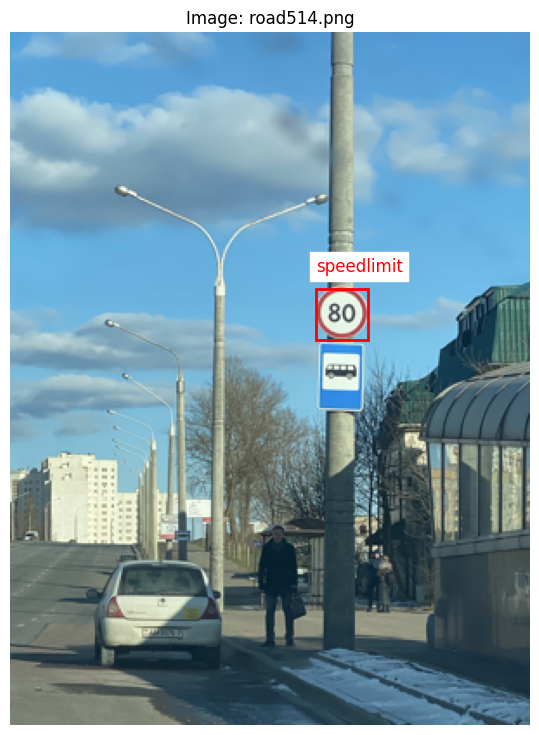

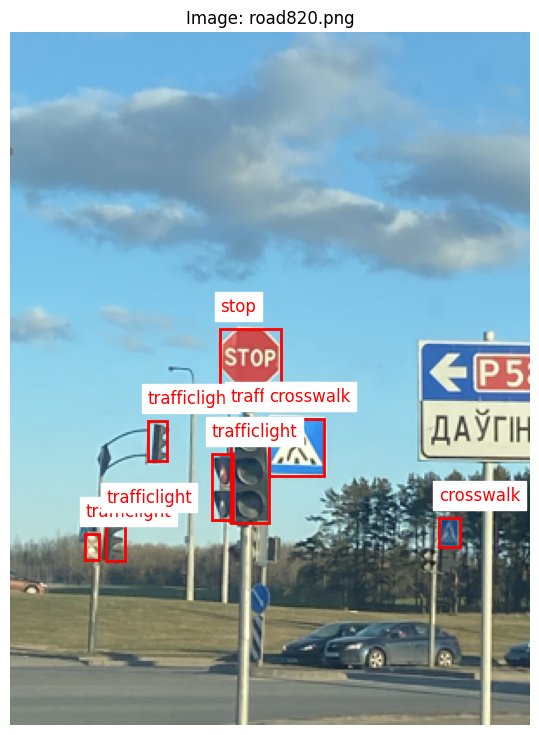

In [6]:

# visualize a few sample images with their bounding boxes
print("\n--- Visualizing Sample Images with Bounding Boxes ---")
num_samples_to_show = 3
if df['image_path'].nunique() >= num_samples_to_show:
    sample_image_paths = random.sample(list(df['image_path'].unique()), num_samples_to_show)
    
    for img_path in sample_image_paths:
        try:
            img = Image.open(img_path)
            fig, ax = plt.subplots(1, figsize=(12, 9))
            ax.imshow(img)
            
            # get all objects for this image
            img_objects = df[df['image_path'] == img_path]
            for _, row in img_objects.iterrows():
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                label = row['label']
                rect_width = xmax - xmin
                rect_height = ymax - ymin
                
                # create a rectangle patch
                rect = patches.Rectangle((xmin, ymin), rect_width, rect_height, 
                                            linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(xmin, ymin - 10, label, color='red', fontsize=12, backgroundcolor='white')
            
            plt.title(f"Image: {os.path.basename(img_path)}")
            ax.axis('off') # hide axes
            plt.show()
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}")
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")
else:
    print("Not enough unique images to display samples.")


# Fine-tuning ResNet18 for Road Sign Classification

To make our model relevant to the specific road signs in our dataset (Speedlimit, Stop, Crosswalk, Trafficlight), we will fine-tune a pre-trained ResNet18 model. Then, we'll perform the Fast Gradient Sign Attack (FGSA) on this specialized model.

- **Data Preparation for Fine-tuning:**
    - We extract cropped images of our target road signs from the dataset using their bounding boxes.
    - These crops are labeled with their specific road sign type/label (e.g., "speedlimit," "stop").
    - The data is split into training and validation sets.

- **Modifying and Fine-tuning ResNet18:**
    - We load a ResNet18 model pre-trained on ImageNet.
    - The final classification layer of ResNet18 (originally for 1000 ImageNet classes) is replaced with a new layer designed for our specific number of road sign classes; only 4 classes in total.
    - The model is then fine-tuned for a few epochs using our prepared dataset of road sign crops. Only the new classification layer is updated during this process.

- **FGSA on the Fine-tuned Road Sign Classifier:**
    - After fine-tuning, we use this specialized ResNet18 model.
    - We select a cropped road sign image.
    - The FGSA attack generates an adversarial perturbation to make our fine-tuned model misclassify this sign into a *different road sign category* (e.g., make it predict "stop" for an actual "speedlimit" sign).

- **Visualizing the Attack:**
    - We'll visualize the original crop, the perturbation, and the adversarially perturbed crop, along with the model's predictions, to see if the attack was successful.


In [7]:
print("------------------------------------------------------------------------------------------------")
print("\n--- Preparing Data for Fine-tuning ---")

# identify unique classes and create mappings
target_classes = df['label'].unique()

if df.empty:
    print(f"CRITICAL: No data found for target classes: {target_classes}. Check your DataFrame `df` and labels.")
else:
    print(f"Using data for classes: {df['label'].unique()}")

class_to_idx = {classname: i for i, classname in enumerate(df['label'].unique())} 
idx_to_class = {i: classname for classname, i in class_to_idx.items()}
num_classes = len(class_to_idx)
print(f"Class mapping: {class_to_idx}")
print(f"Number of classes for fine-tuning: {num_classes}")

# add integer labels to the filtered DataFrame
df['label_idx'] = df['label'].map(class_to_idx)


# preprocessing for fine-tuning (as done in ImageNet training and dataset normalization)
# ResNet expects 224x224 images
finetune_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # based on ImageNet dataset stats
])


# custom PyTorch Dataset for cropped road signs
class RoadSignCropsDataset(Dataset):
    """Custom Dataset for Road Sign Crops"""

    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.df = dataframe
        self.transform = transform
        if len(self.df) == 0:
            raise ValueError("No valid image paths found in the dataframe for RoadSignCropsDataset.")

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.df)

    def __getitem__(self, idx):
        """Get a cropped image and its label from the DataFrame"""
        row = self.df.iloc[idx]
        try:
            full_image = Image.open(row['image_path']).convert("RGB")
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            cropped_image = full_image.crop((xmin, ymin, xmax, ymax))
            label = row['label_idx']

            if self.transform:
                cropped_image = self.transform(cropped_image)
            
            return cropped_image, label
        except FileNotFoundError:
            print(f"Warning: Image not found {row['image_path']} during getitem. Should have been filtered.")
        except Exception as e:
            print(f"Error processing {row['image_path']} for crop: {e}")

if not df.empty:
    # split data into training and validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=11, stratify=df['label_idx'] if num_classes > 1 else None)
    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    # create Datasets and DataLoaders
    try:
        train_dataset = RoadSignCropsDataset(train_df, transform=finetune_preprocess)
        val_dataset = RoadSignCropsDataset(val_df, transform=finetune_preprocess)

        
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    except ValueError as ve:
        print(f"Error creating datasets: {ve}")
        train_loader, val_loader = None, None
else:
    print("Warning: df is empty!")


print("\n--- Modifying ResNet18 for Fine-tuning ---")
fine_tuned_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# freeze all parameters in the network first
for param in fine_tuned_model.parameters():
    param.requires_grad = False # this is important to avoid training all layers

# get the number of input features for the last layer
num_ftrs = fine_tuned_model.fc.in_features # this is the size of the last layer

# replace the last fully connected layer with a new one for our number of classes
fine_tuned_model.fc = nn.Linear(num_ftrs, num_classes) # [512, 4]

# ensure the new fc layer's parameters are trainable
for param in fine_tuned_model.fc.parameters():
    param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuned_model.to(device)
print(f"Fine-tuned model's final layer: {fine_tuned_model.fc}")
print(f"Using device: {device}")


print("\n--- Fine-tuning the Model ---")
if train_loader and val_loader and num_classes > 0:
    criterion = nn.CrossEntropyLoss()

    # optimize only the parameters of the final layer (fine_tuned_model.fc.parameters())
    # but optionally we could also fine-tune more layers: fine_tuned_model.parameters()
    optimizer = optim.Adam(fine_tuned_model.fc.parameters(), lr=0.001)

    num_epochs_finetune = 5 # adjustable
    print(f"Starting fine-tuning for {num_epochs_finetune} epochs...")

    for epoch in range(num_epochs_finetune):
        fine_tuned_model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            if inputs is None or labels is None: continue # Skip if batch is None (due to dataset errors)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = fine_tuned_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1) # get the predicted class
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item() # count correct predictions

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc_train = correct_train / total_train
        
        # validation phase
        fine_tuned_model.eval() # set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                if inputs_val is None or labels_val is None: continue
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = fine_tuned_model(inputs_val)
                loss_v = criterion(outputs_val, labels_val)
                val_loss += loss_v.item() * inputs_val.size(0)
                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        epoch_val_loss = val_loss / len(val_dataset) if len(val_dataset) > 0 else 0
        epoch_acc_val = correct_val / total_val if total_val > 0 else 0
        
        print(f"Epoch {epoch+1}/{num_epochs_finetune} => "+
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc_train:.4f} | "+
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_acc_val:.4f}")

    print("Fine-tuning finished.")

    # save the fine-tuned model (not necessary)
    torch.save(fine_tuned_model.state_dict(), "fine_tuned_road_sign_resnet18.pth")
    print("Fine-tuned model saved as fine_tuned_road_sign_resnet18.pth")
else:
    print("Warning: missing data loaders or no classes to train.")



------------------------------------------------------------------------------------------------

--- Preparing Data for Fine-tuning ---
Using data for classes: ['speedlimit' 'crosswalk' 'stop' 'trafficlight']
Class mapping: {'speedlimit': 0, 'crosswalk': 1, 'stop': 2, 'trafficlight': 3}
Number of classes for fine-tuning: 4
Training samples: 995, Validation samples: 249

--- Modifying ResNet18 for Fine-tuning ---
Fine-tuned model's final layer: Linear(in_features=512, out_features=4, bias=True)
Using device: cpu

--- Fine-tuning the Model ---
Starting fine-tuning for 5 epochs...
Epoch 1/5 => Train Loss: 0.5501, Train Acc: 0.8151 | Val Loss: 0.2368, Val Acc: 0.9598
Epoch 2/5 => Train Loss: 0.2140, Train Acc: 0.9518 | Val Loss: 0.1306, Val Acc: 0.9639
Epoch 3/5 => Train Loss: 0.1710, Train Acc: 0.9508 | Val Loss: 0.1155, Val Acc: 0.9759
Epoch 4/5 => Train Loss: 0.1545, Train Acc: 0.9518 | Val Loss: 0.0902, Val Acc: 0.9839
Epoch 5/5 => Train Loss: 0.1226, Train Acc: 0.9719 | Val Loss: 0.0

# FGSA

Now, we define a function to transform inputs into adversarial examples for the Fast Gradient Sign Attack. After this, we check their effects on the model's predicted labels.


--- FGSA Attack on Fine-tuned Model ---
Selected random sample for attack (index 35 from validation set).
Original Label: stop (Idx: 2)
Fine-tuned Model - Original Prediction for crop: stop (Idx: 2)
Fine-tuned Model - Perturbed Prediction for crop: trafficlight (Idx: 3)


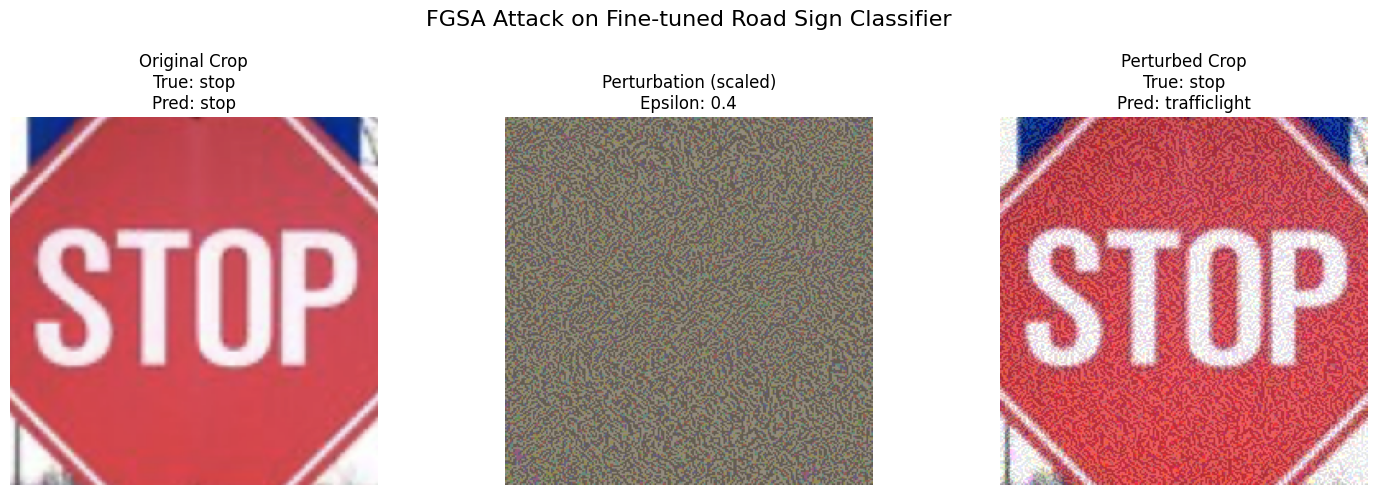

In [ ]:

print("\n--- FGSA Attack on Fine-tuned Model ---")

def fgsa_attack(image_tensor, epsilon, data_grad):
    """
    Perform FGSA attack on the image tensor.
    
    Args:
        image_tensor (torch.Tensor): The input image tensor.
        epsilon (float): The perturbation magnitude.
        data_grad (torch.Tensor): The gradient of the loss with respect to the input image.
    
    Returns:
        perturbed_image (torch.Tensor): The perturbed image tensor.
    """
    sign_data_grad = data_grad.sign()
    perturbed_image = image_tensor + epsilon * sign_data_grad
    # perturbed_image = torch.clamp(perturbed_image, 0, 1) # this line may be adjusted based on normalization
    return perturbed_image

# helper function to denormalize and convert tensor to PIL image for display
def tensor_to_pil(tensor_img):
    """Convert a tensor image to PIL image after denormalizing."""
    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_denorm = inv_normalize(tensor_img.cpu().squeeze(0))
    img_pil = T.ToPILImage()(torch.clamp(img_denorm, 0, 1)) # clamp after denormalizing
    return img_pil


if not df.empty and num_classes > 0 and fine_tuned_model:
    fine_tuned_model.eval()

    if val_loader and len(val_dataset) > 0:
        random_idx = random.randint(0, len(val_dataset) - 1)
        
        # get the image tensor and label directly from val_dataset using the random index
        # val_dataset[random_idx] will call the __getitem__ method of  RoadSignCropsDataset
        image_tensor, label_idx = val_dataset[random_idx] 
        
        # add batch dimension and move to device
        original_crop_tensor_sample = image_tensor.unsqueeze(0).to(device) 
        original_label_idx_sample = label_idx # label_idx from dataset is already an integer
        original_label_name_sample = idx_to_class[original_label_idx_sample]
        
        print(f"Selected random sample for attack (index {random_idx} from validation set).")
        print(f"Original Label: {original_label_name_sample} (Idx: {original_label_idx_sample})")
    else:
        print("Warning: val_dataset is not available or is empty. Cannot select sample for attack.")
        original_crop_tensor_sample = None


    if original_crop_tensor_sample is not None:
        original_crop_tensor_sample.requires_grad = True # enable gradient tracking

        # original prediction
        output_clean = fine_tuned_model(original_crop_tensor_sample)
        original_pred_idx = output_clean.max(1, keepdim=True)[1].item() # get the predicted class
        original_pred_label = idx_to_class.get(original_pred_idx, f"Unknown_idx_{original_pred_idx}") # get corresponding label
        print(f"Fine-tuned Model - Original Prediction for crop: {original_pred_label} (Idx: {original_pred_idx})")

        # calculate loss and gradients
        target_for_loss = torch.LongTensor([original_pred_idx]).to(device) # attack its own prediction
        loss = criterion(output_clean, target_for_loss)
        fine_tuned_model.zero_grad()
        loss.backward()
        data_grad = original_crop_tensor_sample.grad.data

        # perform FGSA
        epsilon = 0.4 # epsilon for fine-tuned model -> adjustable
        perturbed_crop_tensor = fgsa_attack(original_crop_tensor_sample, epsilon, data_grad)

        # perturbed prediction
        output_perturbed = fine_tuned_model(perturbed_crop_tensor)
        perturbed_pred_idx = output_perturbed.max(1, keepdim=True)[1].item()
        perturbed_pred_label = idx_to_class.get(perturbed_pred_idx, f"Unknown_idx_{perturbed_pred_idx}")
        print(f"Fine-tuned Model - Perturbed Prediction for crop: {perturbed_pred_label} (Idx: {perturbed_pred_idx})")

        # visualize
        clean_crop_display = tensor_to_pil(original_crop_tensor_sample.detach())
        perturbed_crop_display = tensor_to_pil(perturbed_crop_tensor.detach())
        
        # calculate perturbation for visualization
        perturbation_viz_tensor = (perturbed_crop_tensor - original_crop_tensor_sample).detach()
        perturbation_viz_pil = tensor_to_pil(perturbation_viz_tensor * 1) # scale for visibility -> adjust factor

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(clean_crop_display)
        plt.title(f"Original Crop\nTrue: {original_label_name_sample}\nPred: {original_pred_label}")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(perturbation_viz_pil)
        plt.title(f"Perturbation (scaled)\nEpsilon: {epsilon}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(perturbed_crop_display)
        plt.title(f"Perturbed Crop\nTrue: {original_label_name_sample}\nPred: {perturbed_pred_label}")
        plt.axis('off')
        plt.suptitle("FGSA Attack on Fine-tuned Road Sign Classifier", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
else:
    print("Warning: either empty DataFrame, no classes, or model not trained.")


# Evalaution




--- Evaluating Model on Perturbed Data with FGSA ---
Evaluating on 249 validation samples.
Epsilon: 0.000  =>  Error Rate on Perturbed Data: 0.0241
Epsilon: 0.001  =>  Error Rate on Perturbed Data: 0.2088
Epsilon: 0.005  =>  Error Rate on Perturbed Data: 0.3373
Epsilon: 0.010  =>  Error Rate on Perturbed Data: 0.2530
Epsilon: 0.015  =>  Error Rate on Perturbed Data: 0.2008
Epsilon: 0.020  =>  Error Rate on Perturbed Data: 0.1647
Epsilon: 0.025  =>  Error Rate on Perturbed Data: 0.1365
Epsilon: 0.030  =>  Error Rate on Perturbed Data: 0.1245
Epsilon: 0.050  =>  Error Rate on Perturbed Data: 0.1044
Epsilon: 0.075  =>  Error Rate on Perturbed Data: 0.1165
Epsilon: 0.100  =>  Error Rate on Perturbed Data: 0.1165
Epsilon: 0.150  =>  Error Rate on Perturbed Data: 0.1566
Epsilon: 0.200  =>  Error Rate on Perturbed Data: 0.2249
Epsilon: 0.300  =>  Error Rate on Perturbed Data: 0.6426
Epsilon: 0.400  =>  Error Rate on Perturbed Data: 0.8153
Epsilon: 0.500  =>  Error Rate on Perturbed Data: 0.7

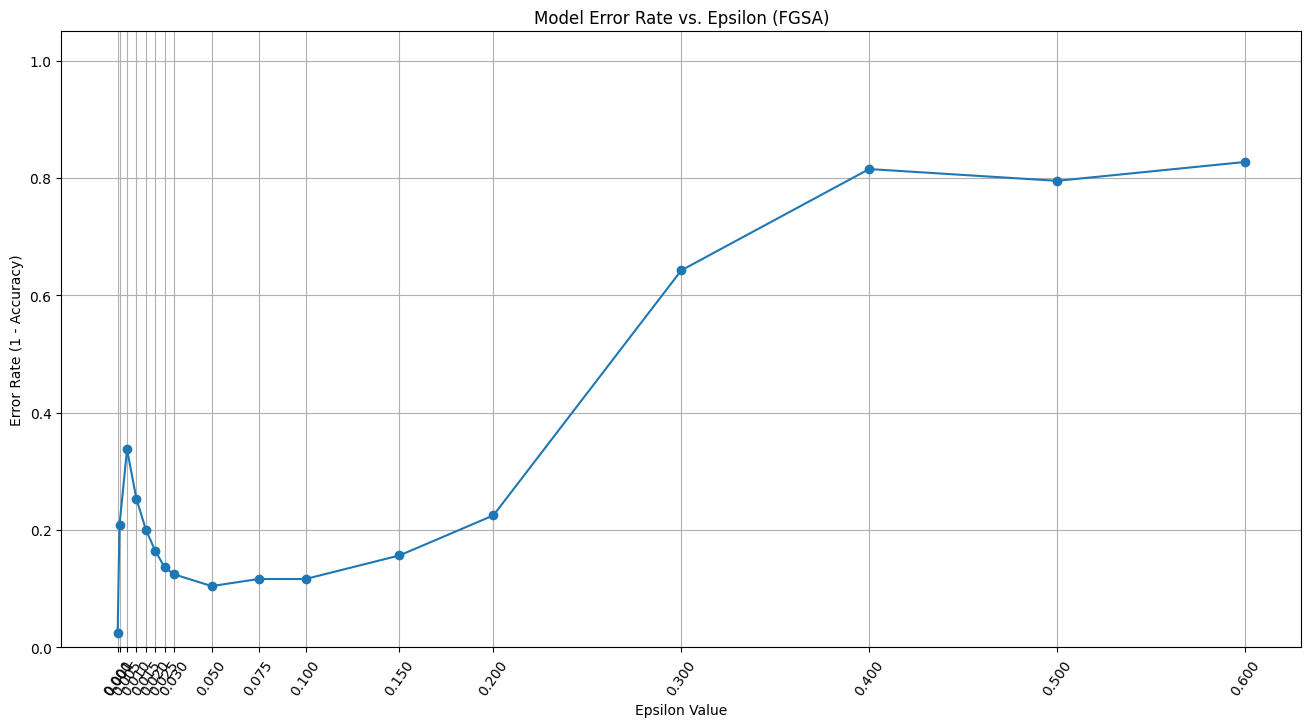

In [14]:
print("\n--- Evaluating Model on Perturbed Data with FGSA ---")

def evaluate_perturbed_error_rate(model, dataset, epsilon_val, current_device, loss_criterion, attack_fn):
    """
    Evaluates the model's error rate on data perturbed by FGSA.
    Args:
        model: The fine-tuned model to evaluate.
        dataset: The PyTorch Dataset (e.g., val_dataset) to use.
        epsilon_val: The epsilon value for the FGSA attack.
        current_device: The device (cpu or cuda) to run on.
        loss_criterion: The loss function (e.g., nn.CrossEntropyLoss).
        attack_fn: The FGSA attack function (e.g., your fgsa_attack).
    Returns:
        float: The error rate (1.0 - accuracy) on the perturbed data.
    """
    model.eval()
    total_samples = 0
    incorrect_predictions = 0
    
    # iterate through the dataset one sample at a time (simpler solution instead of batch processing)
    for i in range(len(dataset)):
        try:
            image_tensor, true_label_idx = dataset[i] # get a single sample

            image_tensor = image_tensor.unsqueeze(0).to(current_device) # add batch dim, move to device
            true_label_idx = torch.tensor([true_label_idx], dtype=torch.long).to(current_device) # make it a tensor
            
            image_tensor.requires_grad = True # enable gradient tracking for the input

            # get model's output for the clean image (needed for gradient calculation based on true label)
            output_clean = model(image_tensor)
            
            # calculate loss against the TRUE label to find adversarial direction (unlike the previous example above)
            loss = loss_criterion(output_clean, true_label_idx)
            model.zero_grad() # clear old gradients
            loss.backward()   # calculate gradients of loss for the input image
            data_grad = image_tensor.grad.data # get the gradients of the input image
            
            # perform FGSA attack
            perturbed_image_tensor = attack_fn(image_tensor, epsilon_val, data_grad)
            
            # get model's prediction on the perturbed image
            with torch.no_grad(): # no need for gradients during this inference
                output_perturbed = model(perturbed_image_tensor)
            
            # get the predicted class index
            _, predicted_idx_perturbed = torch.max(output_perturbed.data, 1)
            
            total_samples += 1
            if predicted_idx_perturbed.item() != true_label_idx.item():
                incorrect_predictions += 1
        
        except Exception as e:
            print(f"Error processing sample {i} during evaluation: {e}. Skipping sample.")
            continue # skip to the next sample?

    if total_samples == 0:
        print("Warning: No samples were processed during evaluation.")
        return None

    error_rate = incorrect_predictions / total_samples
    return error_rate

# define a list of epsilon values to test
# epsilon = 0.0 means evaluating on clean data (perturbation is zero)
epsilons_to_evaluate = [0.0, 0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 
                        0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6] 

attack_error_rates = {}

# check if necessary components are available
if 'fine_tuned_model' in locals() and \
   'val_dataset' in locals() and val_dataset and \
   'device' in locals() and \
   'criterion' in locals() and \
   'fgsa_attack' in locals():

    print(f"Evaluating on {len(val_dataset)} validation samples.")
    for eps in epsilons_to_evaluate:
        current_error_rate = evaluate_perturbed_error_rate(
            fine_tuned_model, 
            val_dataset,      # evaluate on validation dataset
            eps, 
            device, 
            criterion,        # loss function
            fgsa_attack       # FGSA function
        )
        if current_error_rate is not None:
            attack_error_rates[eps] = current_error_rate
            print(f"Epsilon: {eps:.3f}  =>  Error Rate on Perturbed Data: {current_error_rate:.4f}")
        else:
            print(f"Epsilon: {eps:.3f}  =>  Could not calculate error rate (no samples processed).")

    # plotting the results
    if attack_error_rates:
        plt.figure(figsize=(16, 8))
        plt.plot(list(attack_error_rates.keys()), list(attack_error_rates.values()), marker='o', linestyle='-')
        plt.title('Model Error Rate vs. Epsilon (FGSA)')
        plt.xlabel('Epsilon Value')
        plt.ylabel('Error Rate (1 - Accuracy)')
        plt.xticks(epsilons_to_evaluate) # show tested epsilons on x-axis
        plt.xticks(rotation=55)
        plt.grid(True)
        plt.ylim(0, 1.05) # rrror rate is between 0 and 1
        plt.show()
    else:
        print("No error rates were calculated to plot.")
else:
    print("Warning: ensure 'fine_tuned_model', 'val_dataset', 'device', 'criterion', and 'fgsa_attack' are defined before running this evaluation.")



# Tutorial Wrap-up and Next Steps

Congratulations on working through this tutorial on the Fast Gradient Sign Attack (FGSA)!

**What We've Accomplished:**

Throughout this notebook, we've:
1.  Loaded and explored a road sign detection dataset from kaggle, preparing it for a classification task.
2.  Fine-tuned a pre-trained ResNet18 model to specifically classify our target road sign categories, achieving high accuracy on clean validation data (approx. 97.6% in our run).
3.  Implemented FGSA to generate adversarial perturbations.
4.  Applied FGSA to our fine-tuned road sign classifier and visualized its impact on individual samples.
5.  Systematically evaluated the fine-tuned model's performance against FGSA with varying perturbation strengths (epsilon values).

**Key Findings from Evaluation:**

Our evaluation of the fine-tuned model under FGSA revealed several important insights:
-   **Baseline Performance:** The model performed very well on clean data (epsilon = 0.0), with an error rate of only ~2.4%.
-   **Vulnerability Demonstrated:** Even small epsilon values (e.g., 0.01) significantly increased the error rate (to ~30% in our evaluation/test), showing the model's susceptibility to these targeted attacks.
-   **Complex Interaction:** We observed an interesting non-monotonic behavior in the error rate for some epsilon values. This highlights that the impact of adversarial attacks isn't always straightforward and can depend on the specific model, data, and attack parameters.
-   **Effectiveness of Stronger Attacks:** As epsilon increased, the error rate generally rose, with stronger perturbations (e.g., epsilon = 0.4) causing a very high error rate (~77%), effectively fooling the model most of the time.

These results clearly demonstrate that even models performing well on standard metrics can be vulnerable to adversarial attacks. This underscores the importance of considering model robustness in real-world AI applications.

**Where to Go From Here?**

This tutorial provides a foundational understanding of FGSA. The field of adversarial machine learning is vast and rapidly evolving. Here are some ideas for further exploration:

-   **Experiment Further:**
    -   Try different `epsilon` values or a more granular range in the evaluation.
    -   Experiment with fine-tuning other pre-trained architectures or training a simple CNN from scratch.
*   **Explore Other Attacks:**
    -   Learn about and implement more sophisticated iterative attacks like _Projected Gradient Descent (PGD)_, _Basic Iterative Method (BIM)_, which may be more effective for this dataset.
*   **Investigate Defenses:**
    -   Research and try to implement techniques to make models more robust, such as _adversarial training_ as mentioned in the paper, defensive distillation, or input sanitization methods.
*   **Different Tasks:**
    -   Consider how these attacks might apply to other domains beyond image classification or to full object detection models.

Understanding adversarial attacks is crucial for anyone involved in developing or deploying machine learning systems, especially in safety-critical domains. We hope this tutorial has equipped you with a practical example to this important topic!


